In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt


from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

# Получение информации по рубрикам с lenta.ru

In [2]:
url = ("https://lenta.ru/")
page = requests.get(url)
releases = page.text

soup = BeautifulSoup(releases, "lxml")

В первую очередь понимаем, что новости определенной рубрики хранятся на странице этой рубрики. Ищем подходящие теги (тег `"а"` и класс, обозначающий рубрику) для получения части ссылки на интересующие нас рубрики для последующего перехода на них и сбора новостной информации.

In [3]:
soup.findAll ('a', {'class':"rubric item__rubric"})[:5]

[<a class="rubric item__rubric" href="/rubrics/culture/">Культура</a>,
 <a class="rubric item__rubric" href="/rubrics/science/">Наука и техника</a>,
 <a class="rubric item__rubric" href="/rubrics/life/">Из жизни</a>,
 <a class="rubric item__rubric" href="/rubrics/world/">Мир</a>,
 <a class="rubric item__rubric" href="/rubrics/economics/">Экономика</a>]

Все частичные ссылки на рубрики хранятся под одинаковыми тегами (в одинаковых классах), в связи с чем применяем ко всем одинаковый подход. Сначала итерируемся по тегу и классу, а затем, обращаясь к `href`, достаем саму ссылку. Однако, мы сохраняем не только частичные ссылки на рубрики при таком подходе, но и другую ненужную информацию, ввиду чего вводим ограничение на название сохраняемых объектов: все они должны содержать `rubrics/`. Сохраняем только уникальные ссылки и добавляем их к адресу новостного портала `https://lenta.ru`. Получаем список полных ссылок на рубрики.

In [4]:
links0 = []
links = []
for link in soup.findAll ('a', {'class':"rubric item__rubric"}):
    release = link.get ("href")
    if "rubrics/" in str(release):
        if str(release) not in links0:
            'url = ("https://lenta.ru" + str(release))'
            links0.append(release)
            
            
for link in links0:
    url = ("https://lenta.ru" + str(link))
    links.append(url)

In [5]:
links

['https://lenta.ru/rubrics/culture/',
 'https://lenta.ru/rubrics/science/',
 'https://lenta.ru/rubrics/life/',
 'https://lenta.ru/rubrics/world/',
 'https://lenta.ru/rubrics/economics/',
 'https://lenta.ru/rubrics/media/',
 'https://lenta.ru/rubrics/style/',
 'https://lenta.ru/rubrics/ussr/',
 'https://lenta.ru/rubrics/realty/',
 'https://lenta.ru/rubrics/forces/',
 'https://lenta.ru/rubrics/sport/',
 'https://lenta.ru/rubrics/russia/']

### Рубрика `Культура`

Создадим функцию `get_soup_rubric_from_link`, которая берет на вход ссылку на рубрику и отдает объект формата `bs4.BeautifulSoup`.

In [6]:
def get_soup_rubric_from_link(link):
    url = (link)
    page = requests.get(url)
    releases = page.text
    
    soup_rubric = BeautifulSoup(releases, "lxml")
    return(soup_rubric)

Ищем ссылку рубрики `Культура` в списке ссылок рубрик и применяем к ней функцию `get_soup_rubric_from_link`. Аналогично для последующих рубрик.

In [7]:
links[0]

'https://lenta.ru/rubrics/culture/'

In [8]:
soup_culture = get_soup_rubric_from_link(links[0])

Перейдя на страницу рубрики, мы хотим собрать частичные ссылки на новости. Опять же ищем подходящие теги (`div`) и классы (`titles`). Видим, что у новостных ссылок с текстовым содержанием есть разные составляющие (`articles/` и `news/`), после перехода по тегам `а` и `href`. Будем искать по обеих составляющим, так как хотим увеличить размер выборки и, возможно, точность предсказания будущих моделей.

In [9]:
soup_culture.findAll("div", {'class':'titles'})[:4]

[<div class="titles"><h3><a href="/articles/2018/12/11/solzhenitsyn/"><span>«Трупы выбрасывали. Вьюги их заметут»</span></a></h3><div class="rightcol">Девять кругов лагерного ада Александра Солженицына</div></div>,
 <div class="titles"><h3><a href="/news/2018/12/12/nurnberg/"><span>Мединский предложил снять фильм о Нюрнбергском процессе</span></a></h3></div>,
 <div class="titles"><h3><a href="/news/2018/12/12/gipgipura/"><span>Вдова Караченцова объяснила возгласы «Гип-гип ура!» на его поминках</span></a></h3></div>,
 <div class="titles"><h3><a href="/news/2018/12/12/rapputin/"><span>Путин потребовал выяснить причины гонений на рэперов</span></a></h3></div>]

Создаем функцию `get_urls_from_the_rubric`, которая принимает на вход данные по рубрике формата `bs4.BeautifulSoup`, а отдает все собранные по рубрике частичные новостные ссылки. Подход ко всем новостям в рамках одной рубрики одинаков: итерируемся по коду страницы рубрики, находим все теги и классы, оставляем только те уникальные аутпуты, которые соответствуют нашим составляющим в частичных новостных ссылках, и добавляем все ссылки в единый список.

In [10]:
def get_urls_from_the_rubric(soup_rubric):
    links_rubric = []
    for link in soup_rubric.findAll("div", {'class':'titles'}):
        for l in link.findAll("a"):
            release = l.get ("href")
            if "news/" in str(release):
                if str(release) not in links_rubric:
                    links_rubric.append(release)
            elif "articles/" in str(release):
                if str(release) not in links_rubric:
                    links_rubric.append(release)
    return(links_rubric)

Применяем к результату реализации функции `get_soup_rubric_from_link` функцию `get_urls_from_the_rubric`. Аналогично для последующих рубрик.

In [11]:
links_culture = get_urls_from_the_rubric(soup_culture)

Смотрим на первые три сохраненные ссылки в рубрике `Культура` и проверяем, действительно ли они принадлежат данной категории. 

In [12]:
links_culture[:3]

['/articles/2018/12/11/solzhenitsyn/',
 '/news/2018/12/12/nurnberg/',
 '/news/2018/12/12/gipgipura/']

Аналогично для последних трех ссылок.

In [13]:
links_culture[-3:]

['/news/2018/12/09/lev/',
 '/news/2018/12/08/leps/',
 '/news/2018/12/07/gdkmlupost/']

Получив частичную ссылку, дополним ее адресом новостного портала `https://lenta.ru` и преобразуем в формат `bs4.BeautifulSoup`. Найдем все аутпуты с тегом `p`: получаем текст с одной новостной страницы. Запомним, что текст для одной новости нужно будет объединить в один текст.

In [14]:
url = ("https://lenta.ru" + str(links_culture[0]))
ind_release = requests.get(url)
ind_release = ind_release.text
soup_release = BeautifulSoup(ind_release, "lxml")

soup_release.findAll('p')[:2]

[<p class="b-topic__announce">11 декабря исполняется 100 лет со дня рождения <a href="/tags/persons/solzhenitsyn-aleksandr/" target="_blank">Александра Исаевича Солженицына</a>, писателя, публициста, общественного деятеля, лауреата Нобелевской премии по литературе. В начале 1945 года он был арестован, после многомесячных допросов осужден по статье 58 за антисталинские высказывания и приговорен к восьми годам исправительно-трудовых лагерей. Лагерный опыт лег в основу его произведений «Один день Ивана Денисовича», «Архипелаг ГУЛАГ», «В круге первом». <a href="/tags/organizations/lenta-ru/" target="_blank">«Лента.ру»</a> публикует фрагменты текстов Александра Солженицына, описывающие жизнь заключенных в тюрьмах и лагерях того времени.</p>,
 <p><i>«Куда я попал? Завтра меня не погонят в ледяную воду! Сорок грамм сливочного масла!! Черный хлеб — на столах! Не запрещают книг! Можно самому бриться! Надзиратели не бьют зэков! Что за великий день? Что за сияющая вершина? Может быть, я умер? М

Создаем функцию `get_list_of_text_and_rubric`, принимающую на вход результат предшествующей функции и название рубрики, отдающей список с названием рубрики и новостного текста для одной страницы. Применяем выше описанный подход, последовательно добавляя текст в рамках одной новостной страницы.

In [15]:
def get_list_of_text_and_rubric(links_rubric, rubric_name):
    texts = []
    rubric = rubric_name

    for link in links_rubric:
        url = ("https://lenta.ru" + str(link))
        ind_release = requests.get(url)
        ind_release = ind_release.text
        soup_release = BeautifulSoup(ind_release, "lxml")

        t = ""
        for p in soup_release.findAll('p'): 
            t += p.text 
        texts.append((t, rubric))
    return(texts)

Применяем функцию `get_list_of_text_and_rubric` к рубрике `Культура` (всем частичным новостным ссылкам по рубрике). Аналогично для последующих рубрик.

In [16]:
culture_texts = get_list_of_text_and_rubric(links_culture, 'Культура')

Смотрим на первый сохраненный текст и проверяем, действительно ли он принадлежит первой новостной странице по рубрике).

In [17]:
culture_texts[0]

('11 декабря исполняется 100 лет со дня рождения Александра Исаевича Солженицына, писателя, публициста, общественного деятеля, лауреата Нобелевской премии по литературе. В начале 1945 года он был арестован, после многомесячных допросов осужден по статье\xa058 за антисталинские высказывания и приговорен к восьми годам исправительно-трудовых лагерей. Лагерный опыт лег в основу его произведений «Один день Ивана Денисовича», «Архипелаг ГУЛАГ», «В круге первом». «Лента.ру» публикует фрагменты текстов Александра Солженицына, описывающие жизнь заключенных в тюрьмах и лагерях того времени.«Куда я попал? Завтра меня не погонят в ледяную воду! Сорок грамм сливочного масла!! Черный хлеб — на столах! Не запрещают книг! Можно самому бриться! Надзиратели не бьют зэков! Что за великий день? Что за сияющая вершина? Может быть, я умер? Может быть, мне это снится? Мне чудится, я — в раю! — Нет, уважаемый, вы по-прежнему в аду, но поднялись в его лучший, высший круг — в первый. Вы спрашиваете, что 

Проверяем, для всех ли новостных ссылок сохранились тексты.

In [18]:
len(links_culture)

79

In [19]:
len(culture_texts)

79

Создаем функцию `create_rubric_data_frame`, которая принимает на вход список новостного текста и названия рубрики и генерит датафрейм.

In [20]:
def create_rubric_data_frame(rubric_texts):
    return pd.DataFrame(rubric_texts, 
                        columns=['Текст новости','Категория новости'])

Применяем функцию `create_rubric_data_frame` к рубрике `Культура`. Аналогично для последующих рубрик.

In [21]:
df_culture = create_rubric_data_frame(culture_texts)

Проверяем, совпало ли количество строк в датафрейме с количеством частичных новостных ссылок по рубрике и количеством новостных текстов.

In [22]:
len(df_culture)

79

Все сохранилось верно. Новостей больше 30.

In [23]:
df_culture.head(3)

,Текст новости,Категория новости
0,11 декабря исполняется 100 лет со дня рождения...,Культура
1,Министр культуры Владимир Мединский предложил ...,Культура
2,Вдова актера Николая Караченцова Людмила Порги...,Культура


### Рубрика `Спорт`

In [24]:
links[-2]

'https://lenta.ru/rubrics/sport/'

In [25]:
soup_sport = get_soup_rubric_from_link(links[-2])
links_sport = get_urls_from_the_rubric(soup_sport)
sport_texts = get_list_of_text_and_rubric(links_sport, 'Спорт')
df_sport = create_rubric_data_frame(sport_texts)

In [26]:
len(df_sport)

85

In [27]:
df_sport.head(3)

,Текст новости,Категория новости
0,Трехкратный олимпийский чемпион по лыжным гонк...,Спорт
1,Задержанный сотрудниками таможни за незаконный...,Спорт
2,Три года подряд россиянки не отдавали никому з...,Спорт


### Рубрика `Мир`

In [28]:
links[3]

'https://lenta.ru/rubrics/world/'

In [29]:
soup_world = get_soup_rubric_from_link(links[3])
links_world = get_urls_from_the_rubric(soup_world)
world_texts = get_list_of_text_and_rubric(links_world, 'Мир')
df_world = create_rubric_data_frame(world_texts)

In [30]:
len(df_sport)

85

In [31]:
df_world.head(3)

,Текст новости,Категория новости
0,За всю свою историю Евросоюз не вкладывал ни в...,Мир
1,"Польские фермеры, одетые во флуоресцентные жел...",Мир
2,Палата представителей Конгресса США признала г...,Мир


### Рублика `Россия`

In [32]:
links[-1]

'https://lenta.ru/rubrics/russia/'

In [33]:
soup_russia = get_soup_rubric_from_link(links[-1])
links_russia = get_urls_from_the_rubric(soup_russia)
russia_texts = get_list_of_text_and_rubric(links_russia, 'Россия')
df_russia = create_rubric_data_frame(russia_texts)

In [34]:
len(df_russia)

84

In [35]:
df_russia.head(3)

,Текст новости,Категория новости
0,Даша живет в маленьком городке Тайшет в Иркутс...,Россия
1,12 декабря российской Конституции исполнится 2...,Россия
2,В Госдуму внесен пакет проектов о снятии запре...,Россия


In [36]:
# Сохраняем общий датасет в формате csv
df = pd.concat([df_culture.reset_index(drop=True),
                df_sport.reset_index(drop=True), 
                df_world.reset_index(drop=True), 
                df_russia.reset_index(drop=True)], axis=0)
df.to_csv('News.csv')

### a) получение тестового и обучающего набора данных

Чтобы категории были представлены в равной пропорции в тренировочном и тестовом датасетах (Series), реализуем следующий подход. Создадим функцию `create_test_train_datasets`, которая принимает на вход датасет рубрики, `X` рубрики и `y` рубрики и отдает датасеты тренировочных и тестовых выборок для одной категории в пропорции 0.33 (больший датасет для тренировки).

Последовательно разделим все датасеты рубрик в одинаковой пропорции, а затем соединим их в единые базы по тренировке и тесту для `X`, `y`.

Интерация не была произведена на 3-м шаге ввиду того, что решение получилось бы схожим по эффективности.

In [37]:
def create_test_train_datasets(df_rubric, X_0, y_0):
    X = X_0
    y = y_0
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, 
                                                        random_state = 42)
    return (X_train, X_test, y_train, y_test)

In [38]:
df_sets_culture = create_test_train_datasets(df_culture, df_culture["Текст новости"], df_culture["Категория новости"])
df_sets_sport = create_test_train_datasets(df_sport, df_sport["Текст новости"], df_sport["Категория новости"])
df_sets_world = create_test_train_datasets(df_world, df_world["Текст новости"], df_world["Категория новости"])
df_sets_russia = create_test_train_datasets(df_russia, df_russia["Текст новости"], df_russia["Категория новости"])

In [39]:
X_train = df_sets_culture[0].append(df_sets_sport[0], 
                                    ignore_index=True).append(df_sets_world[0], 
                                                              ignore_index=True).append(df_sets_russia[0], 
                                                                                        ignore_index=True)

X_test = df_sets_culture[1].append(df_sets_sport[1], 
                                    ignore_index=True).append(df_sets_world[1], 
                                                              ignore_index=True).append(df_sets_russia[1], 
                                                                                        ignore_index=True)

y_train = df_sets_culture[2].append(df_sets_sport[2], 
                                    ignore_index=True).append(df_sets_world[2], 
                                                              ignore_index=True).append(df_sets_russia[2], 
                                                                                        ignore_index=True)

y_test = df_sets_culture[3].append(df_sets_sport[3], 
                                    ignore_index=True).append(df_sets_world[3], 
                                                              ignore_index=True).append(df_sets_russia[3], 
                                                                                        ignore_index=True)

Видим, что наше решение позволило представить в одинаковой пропорции все категории как для теста, так и для обучения (разница от 0 до 8).

In [40]:
y_test.groupby(y_test).size()

Категория новости
Культура    27
Мир         25
Россия      28
Спорт       29
Name: Категория новости, dtype: int64

In [41]:
y_train.groupby(y_train).size()

Категория новости
Культура    52
Мир         48
Россия      56
Спорт       56
Name: Категория новости, dtype: int64

### б - чистка трениовочного датасета (со стоп-словами)

In [42]:
X_train[0]

'Российский актер Иван Охлобыстин рассказал о своем отношении к «уродливым формам, которые иногда принимает гуманизм», и объяснил, почему считает себя мракобесом. Об этом стало известно из его интервью «Известиям».Охлобыстин признался, что по нынешним временам в нем действительно есть «что-то мракобесное». По его словам, этим понятием его можно описать из-за негативного отношения к гомосексуальности. «Я не то чтобы гомофоб в прямом понимании — ловить сачком, арестовывать, лечить уколами. Но я считаю, что это прямое нарушение всех религиозных установленных норм», — пояснил он.Также актер заявил, что не понимает истории о нарушении права на гендерную идентичность, и выразил обеспокоенность из-за того, что европейским подросткам рассказывают об этом. «И если будет навязываться вот такой норматив, вот со всей этой гомоисторией, то сразу последует целый ряд нарушений законов жизни homo sapiens», — сказал Охлобыстин.Он подчеркнул, что «жизнь для себя» ведет к разложению института семьи, а сл

Рассмотрим текст первой новости. Очистим ее от пунктуации и заменим все большие буквы на маленькие, удалим так же слова на английском языке. Проверим, что все удалилось и сохранилось верно, сравнив с предшествующим аутпутом.

In [101]:
re.sub('[^а-яА-Я]', ' ', X_train[0]).lower()

'российский актер иван охлобыстин рассказал о своем отношении к  уродливым формам  которые иногда принимает гуманизм   и объяснил  почему считает себя мракобесом  об этом стало известно из его интервью  известиям  охлобыстин признался  что по нынешним временам в нем действительно есть  что то мракобесное   по его словам  этим понятием его можно описать из за негативного отношения к гомосексуальности   я не то чтобы гомофоб в прямом понимании   ловить сачком  арестовывать  лечить уколами  но я считаю  что это прямое нарушение всех религиозных установленных норм     пояснил он также актер заявил  что не понимает истории о нарушении права на гендерную идентичность  и выразил обеспокоенность из за того  что европейским подросткам рассказывают об этом   и если будет навязываться вот такой норматив  вот со всей этой гомоисторией  то сразу последует целый ряд нарушений законов жизни                  сказал охлобыстин он подчеркнул  что  жизнь для себя  ведет к разложению института семьи  а сл

Применим подход ко всем новостям (то есть ячейкам в Series), реализуя команды `map` и `apply`.

Созданим функцию `get_lower_russian_and_english_letters`, которая принимает на вход данные формата Series или столбец Dataframe (новостной текст) и отдает данные того же формата (очищенные новостной текст). Применим функцию к тренировочному датасету по `X`.

In [102]:
def get_lower_russian_and_english_letters(data):
    letters_only = data.map(lambda x: re.sub('[^а-яА-Я]', ' ', x))
    return letters_only.apply(str.lower)

In [103]:
X_train1 = get_lower_russian_and_english_letters(X_train)

Размерность датафрема и bag of words.

In [108]:
X_train1.to_frame().shape

(212, 1)

In [109]:
vectorizer0 = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None)
train_data1 = vectorizer0.fit_transform(X_train1)
train_data1.shape

(212, 30205)

Для просмотра частоты слов во всех новостных текстах реализуем следующий подход. Проитерируемся по всему столбцу с новостным контентом, в каждой итерации (то есть новости) разделим текст по пробелу и сохраним результат в список. Далее избавимся от вложенности полученного списка (каждая ячейка - новость - список в общем списке) и посчитаем частоту упоминаний слов.

Создадим функцию `get_dict_of_counts_and_words`, которая примает на вход данные формата Series или столбец Dataframe, а отдает посчитанную частоту значений (строковых) во всем столбце. Применим функцию к очищенному тренировочному датасету по `X`. Аналогично для очищенного датасета с удалением стоп-слов.

In [104]:
def get_dict_of_counts_and_words(data):
    lst = []
    for cell in data:
        x = cell.split(' ')
        lst.append(x)
    l = [item for sublist in lst for item in sublist]
    return Counter(l)

In [105]:
counts = get_dict_of_counts_and_words(X_train1)

Видим, что наиболее популярное слово - это вовсе не слово, а пробел, поэтому сохраним на одно слово больше и затем удалим пробел и его частоту из словаря.

In [113]:
sorted(counts, key=counts.get, reverse=True)[:5]

['', 'в', 'и', 'не', 'на']

In [114]:
counts_max = dict(Counter(counts).most_common(21))

##### Столбчатый график для 20 самых популярных слов (с наличием стоп-слов)

Создадим функцию `Barplot_of_max_words_frequency` для иллюстрации 20 самых популярных слов и их частоты: можно варьровать содержимое словаря, название графика и палитру цветов графика.

Сохраним проитерированные ключи и значения словаря `counts_max` в качестве столбцов в датафрейм, а затем по ним построим столбчатый график. Добавим название графика и повернем слова на графике на 90 градусов.

Применим функцию для очищенного датасета с включеним стоп-слов, аналогично для очищенного датасета без стоп-слов.

In [110]:
def Barplot_of_max_words_frequency(Words, Counts, dictt, title, palette):
    df_counts_max = pd.DataFrame({Words:[i for i in dictt.keys()], 
              Counts:[i for i in dictt.values()]})
    ax = sns.barplot(x = Words, y = Counts, 
            data = df_counts_max, palette=palette)
    ax.set_title(title)
    plt.setp(ax.get_xticklabels(), rotation=90)

In [111]:
del counts_max['']

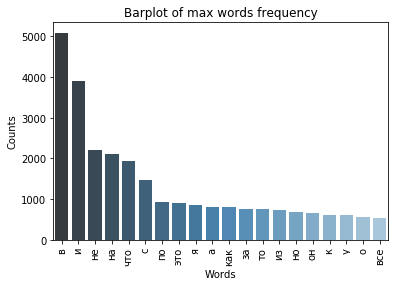

In [112]:
Barplot_of_max_words_frequency('Words', 'Counts', counts_max, 
                               'Barplot of max words frequency', "Blues_d")

Видим, что все слова - это фактически предлоги, союзы и местоимения. Содержательно проитерпретировать их сложно: они содержатся во всех новостях и не являются составляющей, по которой можно было отличить одну рубрику от другой. Чаще всего упоминаются предлоги `в`, `и`, в меньшей степени - слова `о`, `все`.

### в - чистка тренировочного датасета (без стоп-слов)

Видим, что почти все наши популярные слова - это стоп-слова. Удалим их посредством функции `news_to_words` и очистим изначальный тренировочный датасет по `X`, применив немного другую логику.

In [55]:
print(stopwords.words('russian')[:10])

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']


In [56]:
def news_to_words(x):
    letters_only = re.sub('[^а-яА-Я]', ' ', x)
    lower_case = letters_only.lower()
    words = lower_case.split()
    stop_w = set(stopwords.words('russian'))
    words1 = [word for word in words if not word in stop_w]
    return(' '.join(words1))

In [57]:
X_train_clean = X_train.map(lambda x: news_to_words(x))

Размерность датафрейма и bag of words

In [58]:
# размерность
X_train_clean.to_frame().shape

(212, 1)

Размерность bag of words чуть меньше для очищенного датасета с удалением стоп-слов.

In [59]:
# размерность
train_data0 = vectorizer0.fit_transform(X_train_clean)
train_data0.shape

(212, 30063)

In [60]:
counts_clean = get_dict_of_counts_and_words(X_train_clean)
counts_clean_max = dict(Counter(counts_clean).most_common(20))

##### Столбчатый график для 20 самых популярных слов (без стоп-слов)

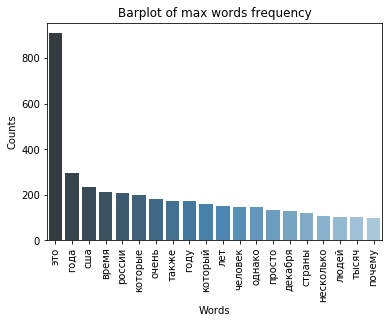

In [61]:
Barplot_of_max_words_frequency('Words', 'Counts', counts_clean_max,
                              'Barplot of max words frequency', "Blues_d")

Почему-то в стоп-словах не содержалось слово `это`, хотя все его видоизменения содержались. Видим, что оно самое популярное слово (частота около 1000). Также часто упоминаются названия стран: `США` и `Россия` (приблизительно с одинаковой частотой). Меньше всего упоминаний у `тысяч` и `почему`. Часть слов достаточно содержательна, по сравнению с предшествующим графиком, где ни одно слово не могло служить в качестве разделителя рубрик.

### г - RandomForest

##### Обучение

In [62]:
vectorizer = CountVectorizer(analyzer = 'word',
                            tokenizer = None,
                            preprocessor = None,
                            stop_words = None,
                            max_features = 5000)

In [63]:
train_data_features = vectorizer.fit_transform(X_train_clean)
train_data_features.shape

(212, 5000)

Видим, что матрица создалась верно: новостей по-прежнему 212 (строки), а количество слов, ограниченное нами до 5000, действительно, равно 5 тысячам (столбцы).

In [64]:
pd.DataFrame(train_data_features.toarray(), columns = vectorizer.get_feature_names())[:3]

,абдулатипов,абсолютно,абсолютного,абсолютной,аварии,августа,августе,автобус,автоматически,автомобилей,...,январе,января,яндекс,японии,японка,японки,ярко,ярославле,ясен,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Обучим модель на данных с удаленными стоп-словами.

In [65]:
forest = RandomForestClassifier(n_estimators = 100, random_state = 50)
forest.fit(train_data_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

In [66]:
y_pred_train = forest.predict(train_data_features)
metrics.accuracy_score(y_train, y_pred_train)

1.0

##### Предсказание и оценка

Для реализации предсказания очистим тестовую выборку, согласно второму методу (с удалением стоп-слов).

In [67]:
X_test_clean = X_test.map(lambda x: news_to_words(x))
test_data_features = vectorizer.transform(X_test_clean)

In [68]:
test_data_features.shape

(109, 5000)

Доля верно предсказанных рубрик достаточно высока.

In [115]:
y_pred_test = forest.predict(test_data_features)
metrics.accuracy_score(y_test, y_pred_test)

0.7706422018348624

##### Самые важные признаки с точки зрения модели

In [70]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = vectorizer.get_feature_names()

In [71]:
print("Топ 15 важных признаков:")

for f in range(15): 
    print("%d. Признак: %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Топ 15 важных признаков:
1. Признак: страны (0.011793)
2. Признак: лиги (0.008432)
3. Признак: сша (0.006336)
4. Признак: сборной (0.005742)
5. Признак: артист (0.005601)
6. Признак: команды (0.005460)
7. Признак: президента (0.005299)
8. Признак: матче (0.005288)
9. Признак: чемпионате (0.004770)
10. Признак: который (0.004372)
11. Признак: победу (0.004062)
12. Признак: человека (0.003917)
13. Признак: министр (0.003896)
14. Признак: работы (0.003642)
15. Признак: также (0.003638)


Среди самых важных признаков с точки зрения модели видим `США`, которые так же были в числе слов с высокой частотой упоминаний в тренировочном очищенном датасете с удаленим стоп-слов. Все слова, за исключением `также` и `который`, важны для разграничения рубрик.

##### Дополнительно - ручной поиск по сетке одного из параметров модели

Единственным заданным параметром при обучении `RandomForest` было количество дерерьев, которые модель должна была реализовать (за исключением заданной случайной последовательности для сохранения результата). 

Попобуем обучить модели с разным набором деревьев с интервалом в 25 штук.

In [72]:
n_estimators = [50, 75, 100, 125, 150, 175, 200]

In [73]:
def train_and_predict_forest(ne, train_data_features, y_train, y_test, test_data_features):
    forest = RandomForestClassifier(n_estimators = ne, random_state = 50)
    forest.fit(train_data_features, y_train)
    y_pred_test = forest.predict(test_data_features)
    score = metrics.accuracy_score(y_test, y_pred_test)
    return score

Видим, что нами было выбрано оптимальное количество деревьев (100), такой же результат верно предсказанных рубрик дает и включение 200 деревьев в модель. Выбираем более экономную модель со 100 деревьями, то есть нашу.

In [74]:
for ne in n_estimators:
    print('n_estimators: ', ne)
    print('Score: ', train_and_predict_forest(ne, train_data_features, y_train, y_test, test_data_features))
    print()

n_estimators:  50
Score:  0.7522935779816514

n_estimators:  75
Score:  0.7614678899082569

n_estimators:  100
Score:  0.7706422018348624

n_estimators:  125
Score:  0.7614678899082569

n_estimators:  150
Score:  0.7614678899082569

n_estimators:  175
Score:  0.7614678899082569

n_estimators:  200
Score:  0.7706422018348624



### д - MultinomialNB

При обучении `MultinomialNB` будем использовать тот же датасет, что и при обучении `RandomForest`, только немного изменим параметры `CountVectorizer`.

In [75]:
count_vectorizer = CountVectorizer(max_features = 5000)
count_train = count_vectorizer.fit_transform(X_train_clean.values)
count_test = count_vectorizer.transform(X_test_clean.values)

In [76]:
pd.DataFrame(count_train.toarray(), columns = count_vectorizer.get_feature_names())[:3]

,абдулатипов,абсолютно,абсолютного,абсолютной,аварии,августа,августе,автобус,автоматически,автомобилей,...,январе,января,яндекс,японии,японка,японки,ярко,ярославле,ясен,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,2,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
nb_classifier = MultinomialNB()

In [78]:
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, pred)

0.8807339449541285

Результат предсказания (по сравнению с `RandomForest`) получился на 1/10 выше и стал равен при округлении 0.9. Соответсвенно, выбираем модель `MultinomialNB`.

##### Дополнительно - ручной поиск по сетке одного из параметров модели

В качестве параметра выбираем величину сглаживания модели (`alpha`).

In [79]:
alphas = np.arange(0,1,0.1)

In [80]:
def train_and_predict_nb(alpha, count_train, y_train, count_test, y_test):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(count_train, y_train)
    pred = nb_classifier.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    return score

Небольшое сглаживание на уровне 0.2 дает нам лучший результат, который остается неизмненным при увеличении сглаживания. Соответственно, делаем выбор в пользу наиболее экономной модели - со сглаживанием в 0.2.

In [81]:
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict_nb(alpha, count_train, y_train, count_test, y_test))
    print()

Alpha:  0.0
Score:  0.7339449541284404

Alpha:  0.1
Score:  0.8623853211009175

Alpha:  0.2
Score:  0.8807339449541285

Alpha:  0.30000000000000004
Score:  0.8807339449541285

Alpha:  0.4
Score:  0.8807339449541285

Alpha:  0.5
Score:  0.8807339449541285

Alpha:  0.6000000000000001
Score:  0.8807339449541285

Alpha:  0.7000000000000001
Score:  0.8807339449541285

Alpha:  0.8
Score:  0.8807339449541285

Alpha:  0.9
Score:  0.8807339449541285



C:\Users\Alii\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


# Модель LDA

При обучении `LDA` будем использовать тот же датасет, что и при обучении `RandomForest`и `MultinomialNB`.

Количество топиков было определено эмпирическим путем (то есть перебором) и знанием, что изначально было 4 топика: `Культура`, `Спорт`, `Россия` и `Мир`. Соответсвенно, модель предсказывает для 4 возможных топиков.

In [117]:
lda_model_4 = LatentDirichletAllocation(n_components=4,           
                                      max_iter=10,               
                                      random_state=42,          
                                      batch_size=128,            
                                      evaluate_every = -1,       
                                      n_jobs = -1, 
                                     )

lda_output = lda_model_4.fit_transform(count_train)

C:\Users\Alii\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


Выведим топики, которые сгенерировала модель.

In [84]:
def print_top_words (model, feature_names, n_top_words): 
    for index, topic in enumerate (model.components_):
        message = '\nTopic #{}\n'.format (index)
        message += ' '.join([feature_names[i] for i in topic.argsort()[:-n_top_words -1: -1 ]])
        print (message)
        print ('='*70)

Первый топик можно определи в качестве культуры,
2 - мир,
3 - Россия,
4 - спорт.

То есть те же категории, что и изначально были даны.

In [119]:
n_top_words = 60
features_names = count_vectorizer.get_feature_names()
print_top_words(lda_model_4, features_names, n_top_words)


Topic #0
это очень который года время которые просто нам рэп россии птаха люди поэтому лет ру году фильм нужно свое кажется загитова почему также которая какие знаю вопрос декабря те сказал человек место именно происходит кроме творчество группы самом слова сделать каждый ленты сегодня например вообще музыку могу говорит деле стала мира говорить эта женщин своей год женщина должны истории концерт

Topic #1
это сша года россии которые время году также очень человек однако лет страны который просто тысяч несколько людей стране почему власти человека например против пока декабря именно люди президента жизни ру поэтому могут нужно стал процентов жизнь своей хотя дело тех будут китай вообще никто президент которая вопрос свои стороны сын деньги государства те долларов партии словам должны около государство

Topic #2
маларчук декабря клинт место это мира получил концерт момент сообщает баффало мурад логинов российский врачи бе вратарь мстители ноябре больницу стало боялся кубка иг пишет тре

##### Предсказание 5 новостей из тестовой выборки

In [120]:
rand_test_5 = X_test_clean.sample(n=5, random_state=50)
count_test_5 = count_vectorizer.transform(rand_test_5)

In [121]:
rand_test_5

50    московский спартак обыграл махачкалинский анжи...
16    российский писатель захар прилепин воевать дон...
42    российская фигуристка алина загитова рассказал...
25    месяц выдался тяжелым отечественных исполнител...
65    россия отправит венесуэлу бомбардировщики ту с...
Name: Текст новости, dtype: object

In [122]:
topic_probability_scores = lda_model_4.transform(count_test_5)

`Первая` новость (про спартак) оценена верно - спорт (большая вероятность попадания у 4 топика);

`Вторая` (про российского писателя) - не совсем верно - мир (но так же велика вероятность попадания в категорию культуры, причем вероятности незначимо отличны);

`Третья` (про российскую фигуристку) - не совсем верно - культура (но так же велика вероятность попадания в категорию спорта, причем вероятности незначимо отличны);

`Четвертая` (про отечественных исполнителей) - верно - культура;

`Пятая` (про отношения Венесуэлы и России) - верно - мир.

В целом модель прогнозирует адекватно: либо правильно, либо близко к правильному ответу (когда новость может быть рассмотрена с двух точек зрения, то есть может быть присвоена двум топикам одновременно. Как, например, третья новость).

In [123]:
print(topic_probability_scores)

[[4.15061992e-03 2.42998055e-01 3.95336891e-03 7.48897956e-01]
 [1.49378929e-01 8.40379999e-01 5.08114189e-03 5.15992981e-03]
 [8.80731841e-01 4.11795790e-03 3.72172727e-03 1.11428473e-01]
 [6.47589144e-01 3.46462924e-01 6.89349969e-04 5.25858197e-03]
 [3.17726943e-03 9.90451919e-01 3.16200171e-03 3.20880993e-03]]


##### Дополнительно - визуализация главных слов топиков

In [124]:
topic_1 = lda_model_4.components_[0]
topic_2 = lda_model_4.components_[1]
topic_3 = lda_model_4.components_[2]
topic_4 = lda_model_4.components_[3]

In [125]:
tf_feature_names = count_vectorizer.get_feature_names()

In [126]:
first_topic_words = [tf_feature_names[i] for i in topic_1.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in topic_2.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in topic_3.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in topic_4.argsort()[:-50 - 1 :-1]]

In [127]:
def get_WorldCloud_for_each_topic(topic_words):
    cloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(topic_words)) 
    return cloud

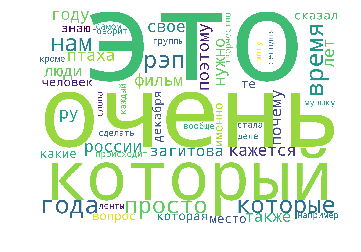

In [128]:
# Культура
firstcloud = get_WorldCloud_for_each_topic(first_topic_words)
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

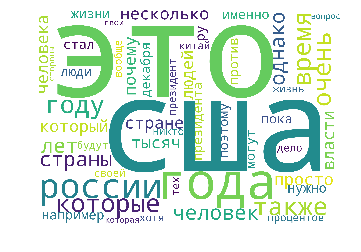

In [129]:
# Мир
secondcloud = get_WorldCloud_for_each_topic(second_topic_words)
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

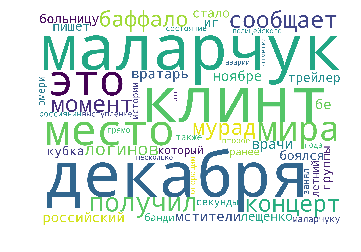

In [130]:
# Россия
thirdcloud = get_WorldCloud_for_each_topic(third_topic_words)
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

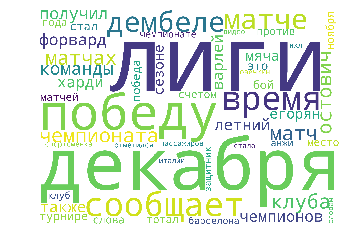

In [131]:
 # Спорт
fourthcloud = get_WorldCloud_for_each_topic(fourth_topic_words)
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()